
# Sommelier's Nose: A Wine Classifier

In an effort to understand the impact of different optimization methods on the training and validation accuracy of classic statistical learning models, I created a logistic regression classifier **from scratch** based on 6,000 sample points from the `wine` dataset. The project only uses `sklearn`, `scipy`, and `numpy` to handle basic preprocessing and algebraic tasks.

## General Imports

In [47]:
from sklearn import model_selection
from sklearn import preprocessing
import numpy as np
import pandas as pd
from scipy import io
from scipy.special import expit
import seaborn as sns
from matplotlib import pyplot as plt
np.random.seed(78)

In [48]:
dataset = io.loadmat(f'/dataset/data.mat')

## Preprocessing & Model Setup

In [49]:
# Creating a dataframe just to inspect and understand the design matrix
df = pd.DataFrame(data = dataset["X"], columns=dataset["description"])
df["label"] = dataset["y"]

In [50]:
# Splitting the data for validation and normalizing features
np.random.seed(78)
def normalize_training(dframe):
  return pd.DataFrame([(dframe[c] - dframe[c].mean()) / dframe[c].std() for c in dframe.columns]).transpose()

class Process:
  def __init__(self, dframe, test_p, test = None):
    if test is not None:
      training = dframe
      validation = test
    else:
      training, validation = model_selection.train_test_split(dframe, 
                                                            test_size=test_p, 
                                                            shuffle=True, 
                                                            random_state=78)
      self.y_val = validation["label"]
      
    self.y_train = training["label"]
    means = training.mean()
    std = training.std()
    self.X_train = pd.DataFrame([(training[c] - means[c]) / std[c] for c in training.columns]).transpose()
    self.X_train.drop("label", axis = 1)
    self.X_val = pd.DataFrame([(validation[c] - means[c]) / std[c] for c in validation.columns]).transpose()

  def get(self):
    return self.X_train, self.y_train, self.X_val, self.y_val

  def get_test(self):
    return self.X_train, self.y_train, self.X_val

# Creating the Logistic Regression model class
class LRModel:
  def __init__(self, X, y, reg, epsilon):
    X["fictitious"] = np.ones(X.shape[0]) 
    self.X = X.to_numpy()
    self.y = y
    self.reg = reg
    self.epsilon = epsilon

    self.w = np.zeros(X.shape[1])

    # This line initializes the vector s so that it can be used to set the first step of GD
    self.regression_fn(self.w)

  def logistic_fn(self, gamma):
    return expit(-gamma)

  def regression_fn(self, w):
    self.s = np.array([self.logistic_fn(np.dot(x, w)) for x in self.X])
  
  def cost_fn(self, y, z):
    reg_term = self.reg * np.linalg.norm(self.w)
    cost = np.dot(y, np.log(z)) + np.dot(np.ones(y.shape[0]) - y, np.log(np.ones(z.shape[0]) - z))
    fn = reg_term - cost
    return fn

  def get_params(self):
    return self.cost_fn, self.y. self.s, self.w

# Creating the Batch Descent child class

class GradientDescent(LRModel):
  def __init__(self, X, y, reg, epsilon, n):
    LRModel.__init__(self, X, y, reg, epsilon)
    self.cost_values = [self.cost_fn(self.y, self.s)]
    self.n = n
    
  def fit(self):
    for i in range(1, self.n + 1):
      step_value = self.w * self.reg + np.dot(np.transpose(self.X), (self.y - self.s))
      self.w = self.w - self.epsilon * (step_value) # Updates w
      self.regression_fn(self.w) # Updates s
      cv = self.cost_fn(self.y, self.s)
      self.cost_values.append(cv)
    return self, self.cost_values

In [51]:
# Creating the Stochastic Descent child class

class StochasticDescent(LRModel):
  def __init__(self, X, y, reg, epsilon, it):
    LRModel.__init__(self, X, y, reg, epsilon)
    self.random_x = np.random.randint(0, X.shape[0], it)
    self.cost_values = list([self.cost_fn(self.y, self.s)])
    self.it = it
    self.regression_fn(self.w)
    
  def fit(self, constant = True):
    i = 0
    for x in self.random_x[1:]:
      i += 1
      x_j = self.X[x]
      s_j = self.logistic_fn(np.dot(x_j, self.w))
      step_value = self.reg * self.w - self.it * (self.y[x] - s_j) * x_j.transpose()
      if (constant == True):
        self.w = self.w + self.epsilon * (step_value)
      else:
        self.w = self.w + (self.epsilon / i) * step_value
      self.regression_fn(self.w)
      v = self.cost_fn(self.y, self.s)
      self.cost_values.append(v)
    return self, self.cost_values

## Comparing Training Outcomes

### Plot - Batch Gradient Descent

In [ ]:
# Plot for Batch Gradient Descent
y_train = df["label"]
X_train = normalize_training(df.copy().drop("label", axis = 1))
gd = GradientDescent(X_train, y_train, 0.1, 0.0003, 4000)
gd, cost_values = gd.fit()

sns.lineplot(x = range(0, gd.n + 1), y = cost_values)
plt.title("Value of Cost Function vs. Number of Training Iterations for Batch Gradient Descent")
plt.xlabel("Training Iterations Completed")
plt.ylabel("Value of Cost Function $J(h)$")

### Plot - Stochastic Gradient Descent

In [ ]:
y_train_SGD = df["label"]
X_train_SGD = normalize_training(df.copy().drop("label", axis = 1))

# Plot for Stochastic Gradient Descent with constant step-size

SGD = StochasticDescent(X_train_SGD, y_train_SGD, 0.3, 0.00001, 4000)
SGD, cost_values = SGD.fit()
sns.lineplot(y = cost_values, x = range(len(cost_values)))
plt.title("Value of Cost Function vs. Number of Training Iterations for Stochastic Gradient Descent")
plt.xlabel("Training Iterations Completed")
plt.ylabel("Value of Cost Function $J(h)$")

### Plot - Stochastic Gradient Descent with Decay-Factor

In [ ]:
# Plot for Stochastic Gradient Descent with shrinking step-size and delta = 0.00008

SGD_shrinking = StochasticDescent(X_train_SGD, y_train_SGD, 0.3, 0.00008, 4000)
SGD_shrinking, cost_values_shrinking = SGD_shrinking.fit(constant = False)
sns.lineplot(y = cost_values_shrinking, x = range(len(cost_values_shrinking)))
plt.title("Value of Cost Function vs. Number of Training Iterations for SGD with shrinking step-size $\delta = 8 * (0.1)^5$")
plt.xlabel("Training Iterations Completed")
plt.ylabel("Value of Cost Function $J(h)$")

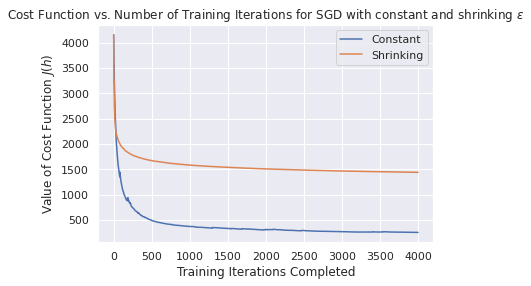

In [ ]:
sns.lineplot(y = cost_values, x = range(len(cost_values)), label = "Constant")
sns.lineplot(y = cost_values_shrinking, x = range(len(cost_values_shrinking)), label = "Shrinking")
plt.title("Cost Function vs. Number of Training Iterations for SGD with constant and shrinking $\epsilon$")
plt.xlabel("Training Iterations Completed")
plt.ylabel("Value of Cost Function $J(h)$")
plt.legend()

### Kaggle Code

In [ ]:
# Code to generate test predictions for Kaggle
np.random.seed(78)
def bgd_classify(w, x):
  w_x = np.dot(w, x.transpose())
  return np.round(expit(-w_x))

X_train, y_train, X_test = Process(df, test_p = 0, test = pd.DataFrame(dataset["X_test"])).get_test()
bgd = GradientDescent(X_train, y_train, 0.1, 0.0003, 4000)
bgd, c_vals = bgd.fit()
w = bgd.w[:-2]
pred = [int(bgd_classify(w, x)) for x in X_test.to_numpy()]

test_predictions = (np.array(pred)).reshape(-1, 1)
predictions = pd.DataFrame(test_predictions, columns = ["Category"])
predictions["Id"] = np.arange(1, 498)
kdf = pd.DataFrame()
kdf["Id"] = np.arange(1, 498)
kdf["Category"] = predictions["Category"]
kdf.to_csv("wine_test_preds.csv", index=False)